--- Training DenseNet-121 on Pneumonia Dataset | Device: cuda ---
Data Loaded: 5216 train images and 640 validation images (val + test merged).


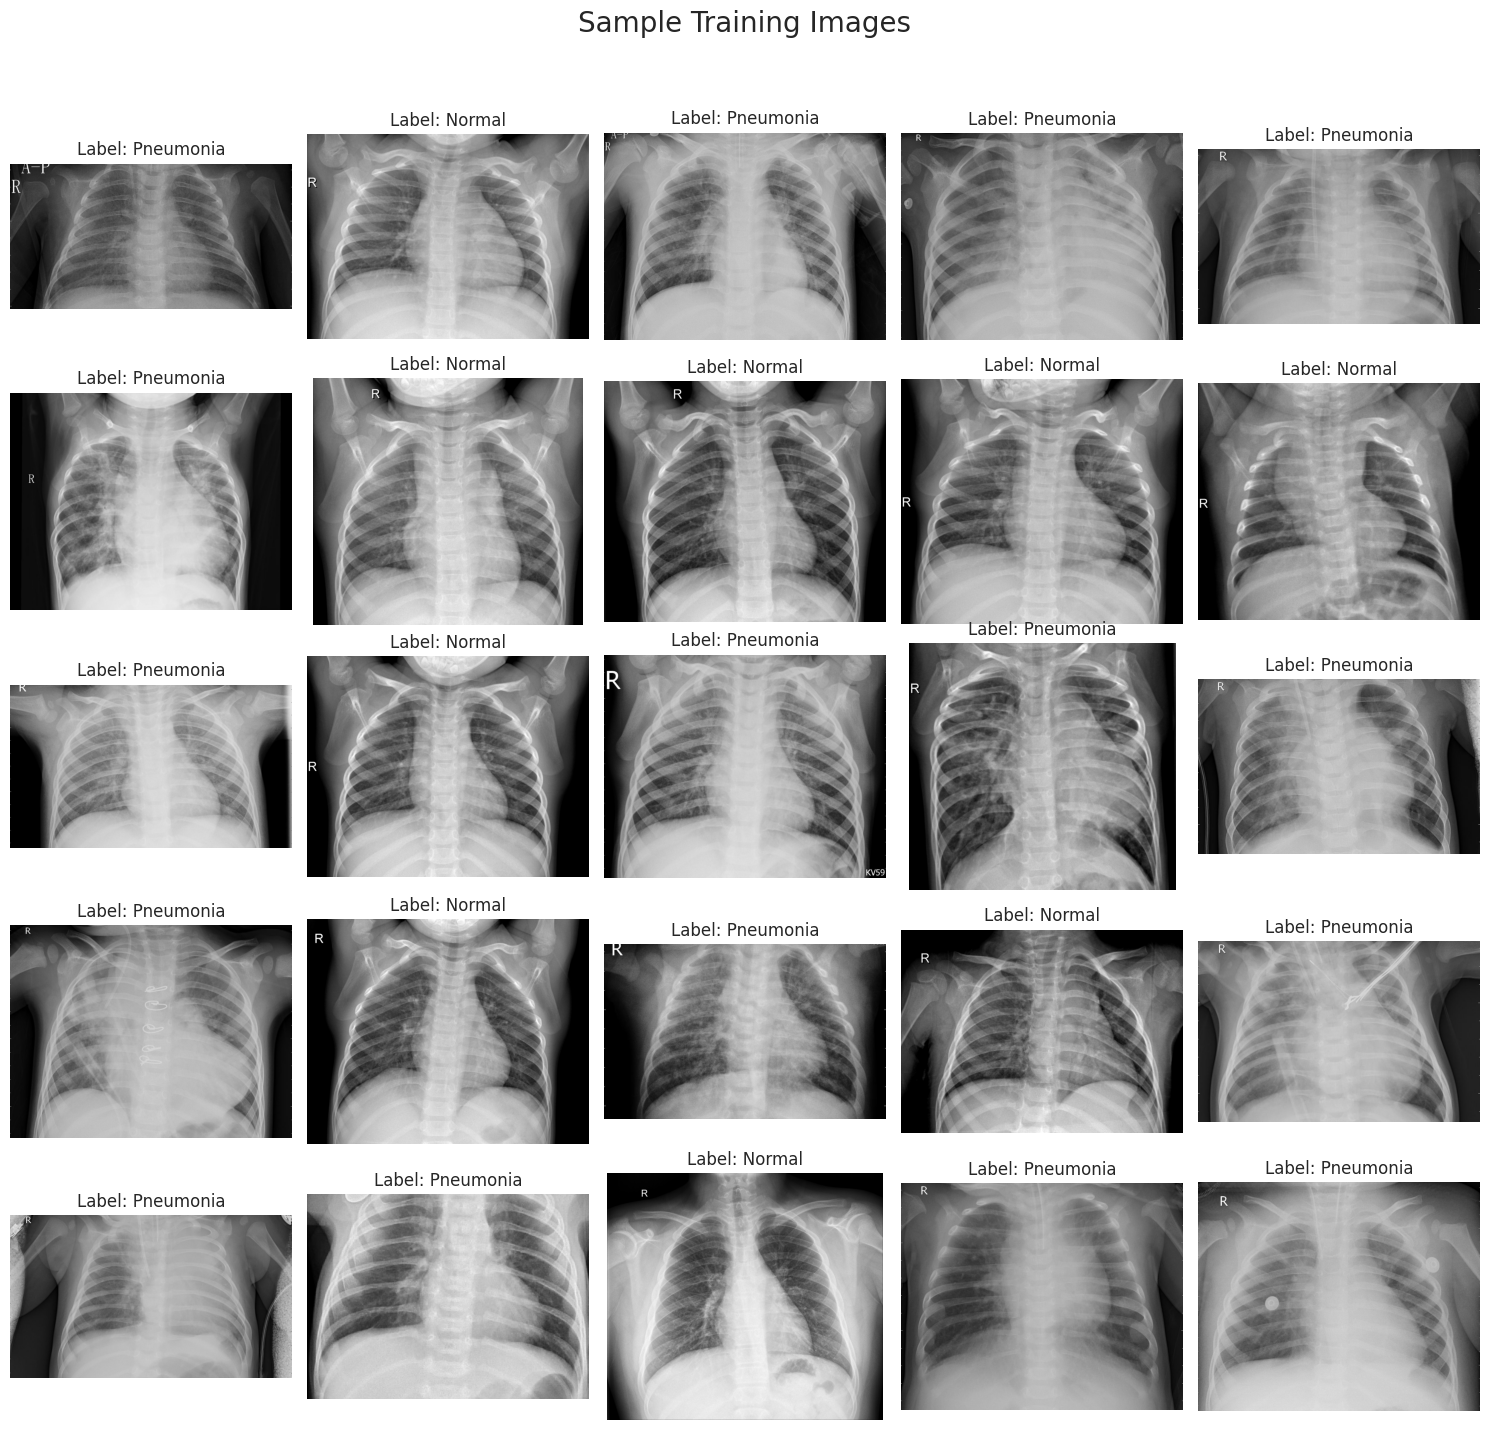

Class Imbalance: 1341 Normal vs. 3875 Pneumonia. Using pos_weight: 0.3461

--- Epoch 1/5 ---


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Epoch 1: Train Loss: 0.0848 | Train Acc: 0.9243 | Val Loss: 0.4439 | Val Acc: 0.8422
Validation loss improved (inf --> 0.4439). Saving model...

--- Epoch 2/5 ---


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s]


Epoch 2: Train Loss: 0.0408 | Train Acc: 0.9720 | Val Loss: 0.2376 | Val Acc: 0.9125
Validation loss improved (0.4439 --> 0.2376). Saving model...

--- Epoch 3/5 ---


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 3: Train Loss: 0.0279 | Train Acc: 0.9801 | Val Loss: 0.8009 | Val Acc: 0.7844

--- Epoch 4/5 ---


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s]


Epoch 4: Train Loss: 0.0211 | Train Acc: 0.9849 | Val Loss: 0.2078 | Val Acc: 0.9266
Validation loss improved (0.2376 --> 0.2078). Saving model...

--- Epoch 5/5 ---


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


Epoch 5: Train Loss: 0.0217 | Train Acc: 0.9841 | Val Loss: 0.5703 | Val Acc: 0.8328


--- 📈 Final Evaluation on VALIDATION SET (Merged Val+Test) ---
--- Loaded best model from best_model.pth for final evaluation. ---


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


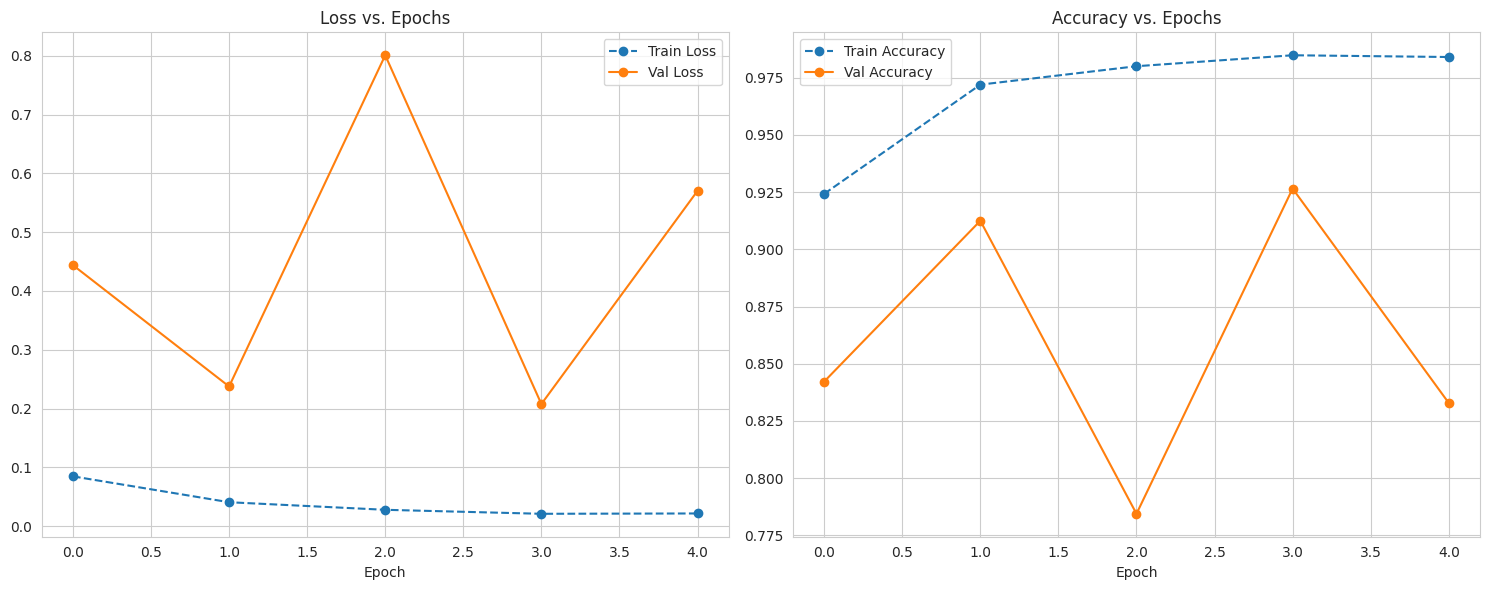

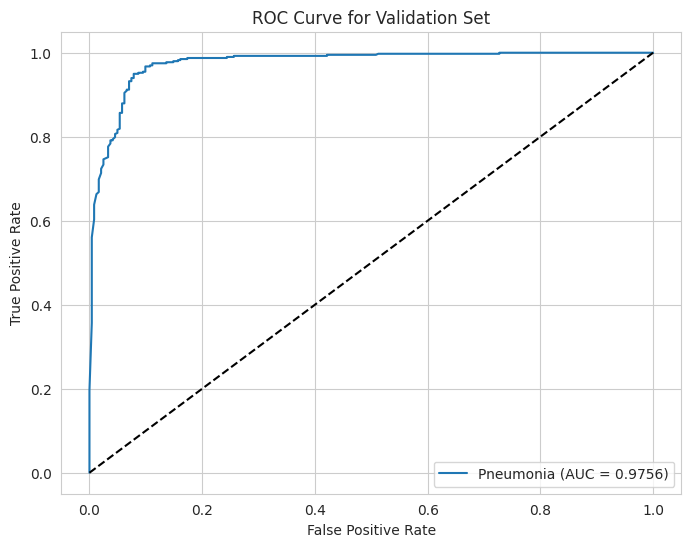

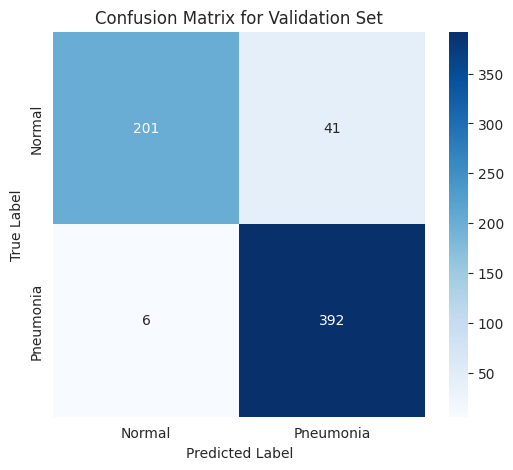


   Final Metrics on Merged Validation Set
   Metric    Score
 Accuracy 0.926562
Precision 0.905312
   Recall 0.984925
 F1-Score 0.943442
      MCC 0.845368
    AUROC 0.975554



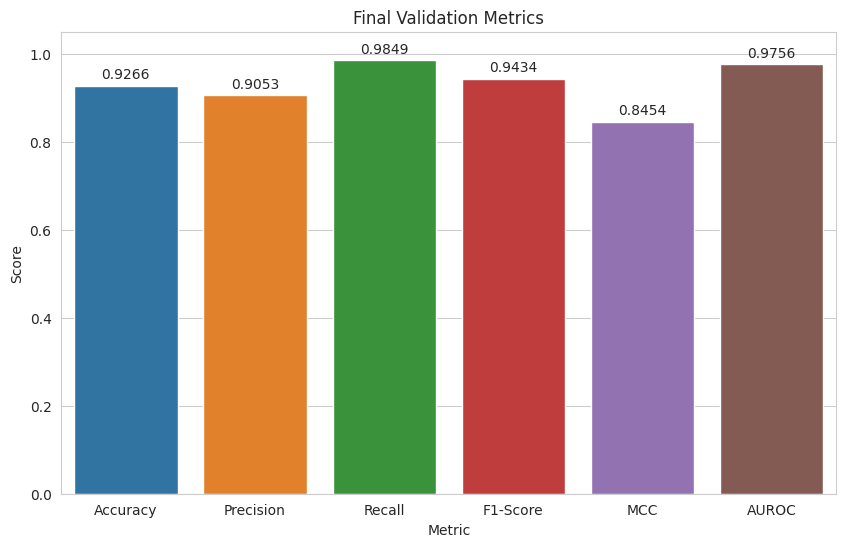


--- 🧠 Performing XAI Analysis (Grad-CAM) ---


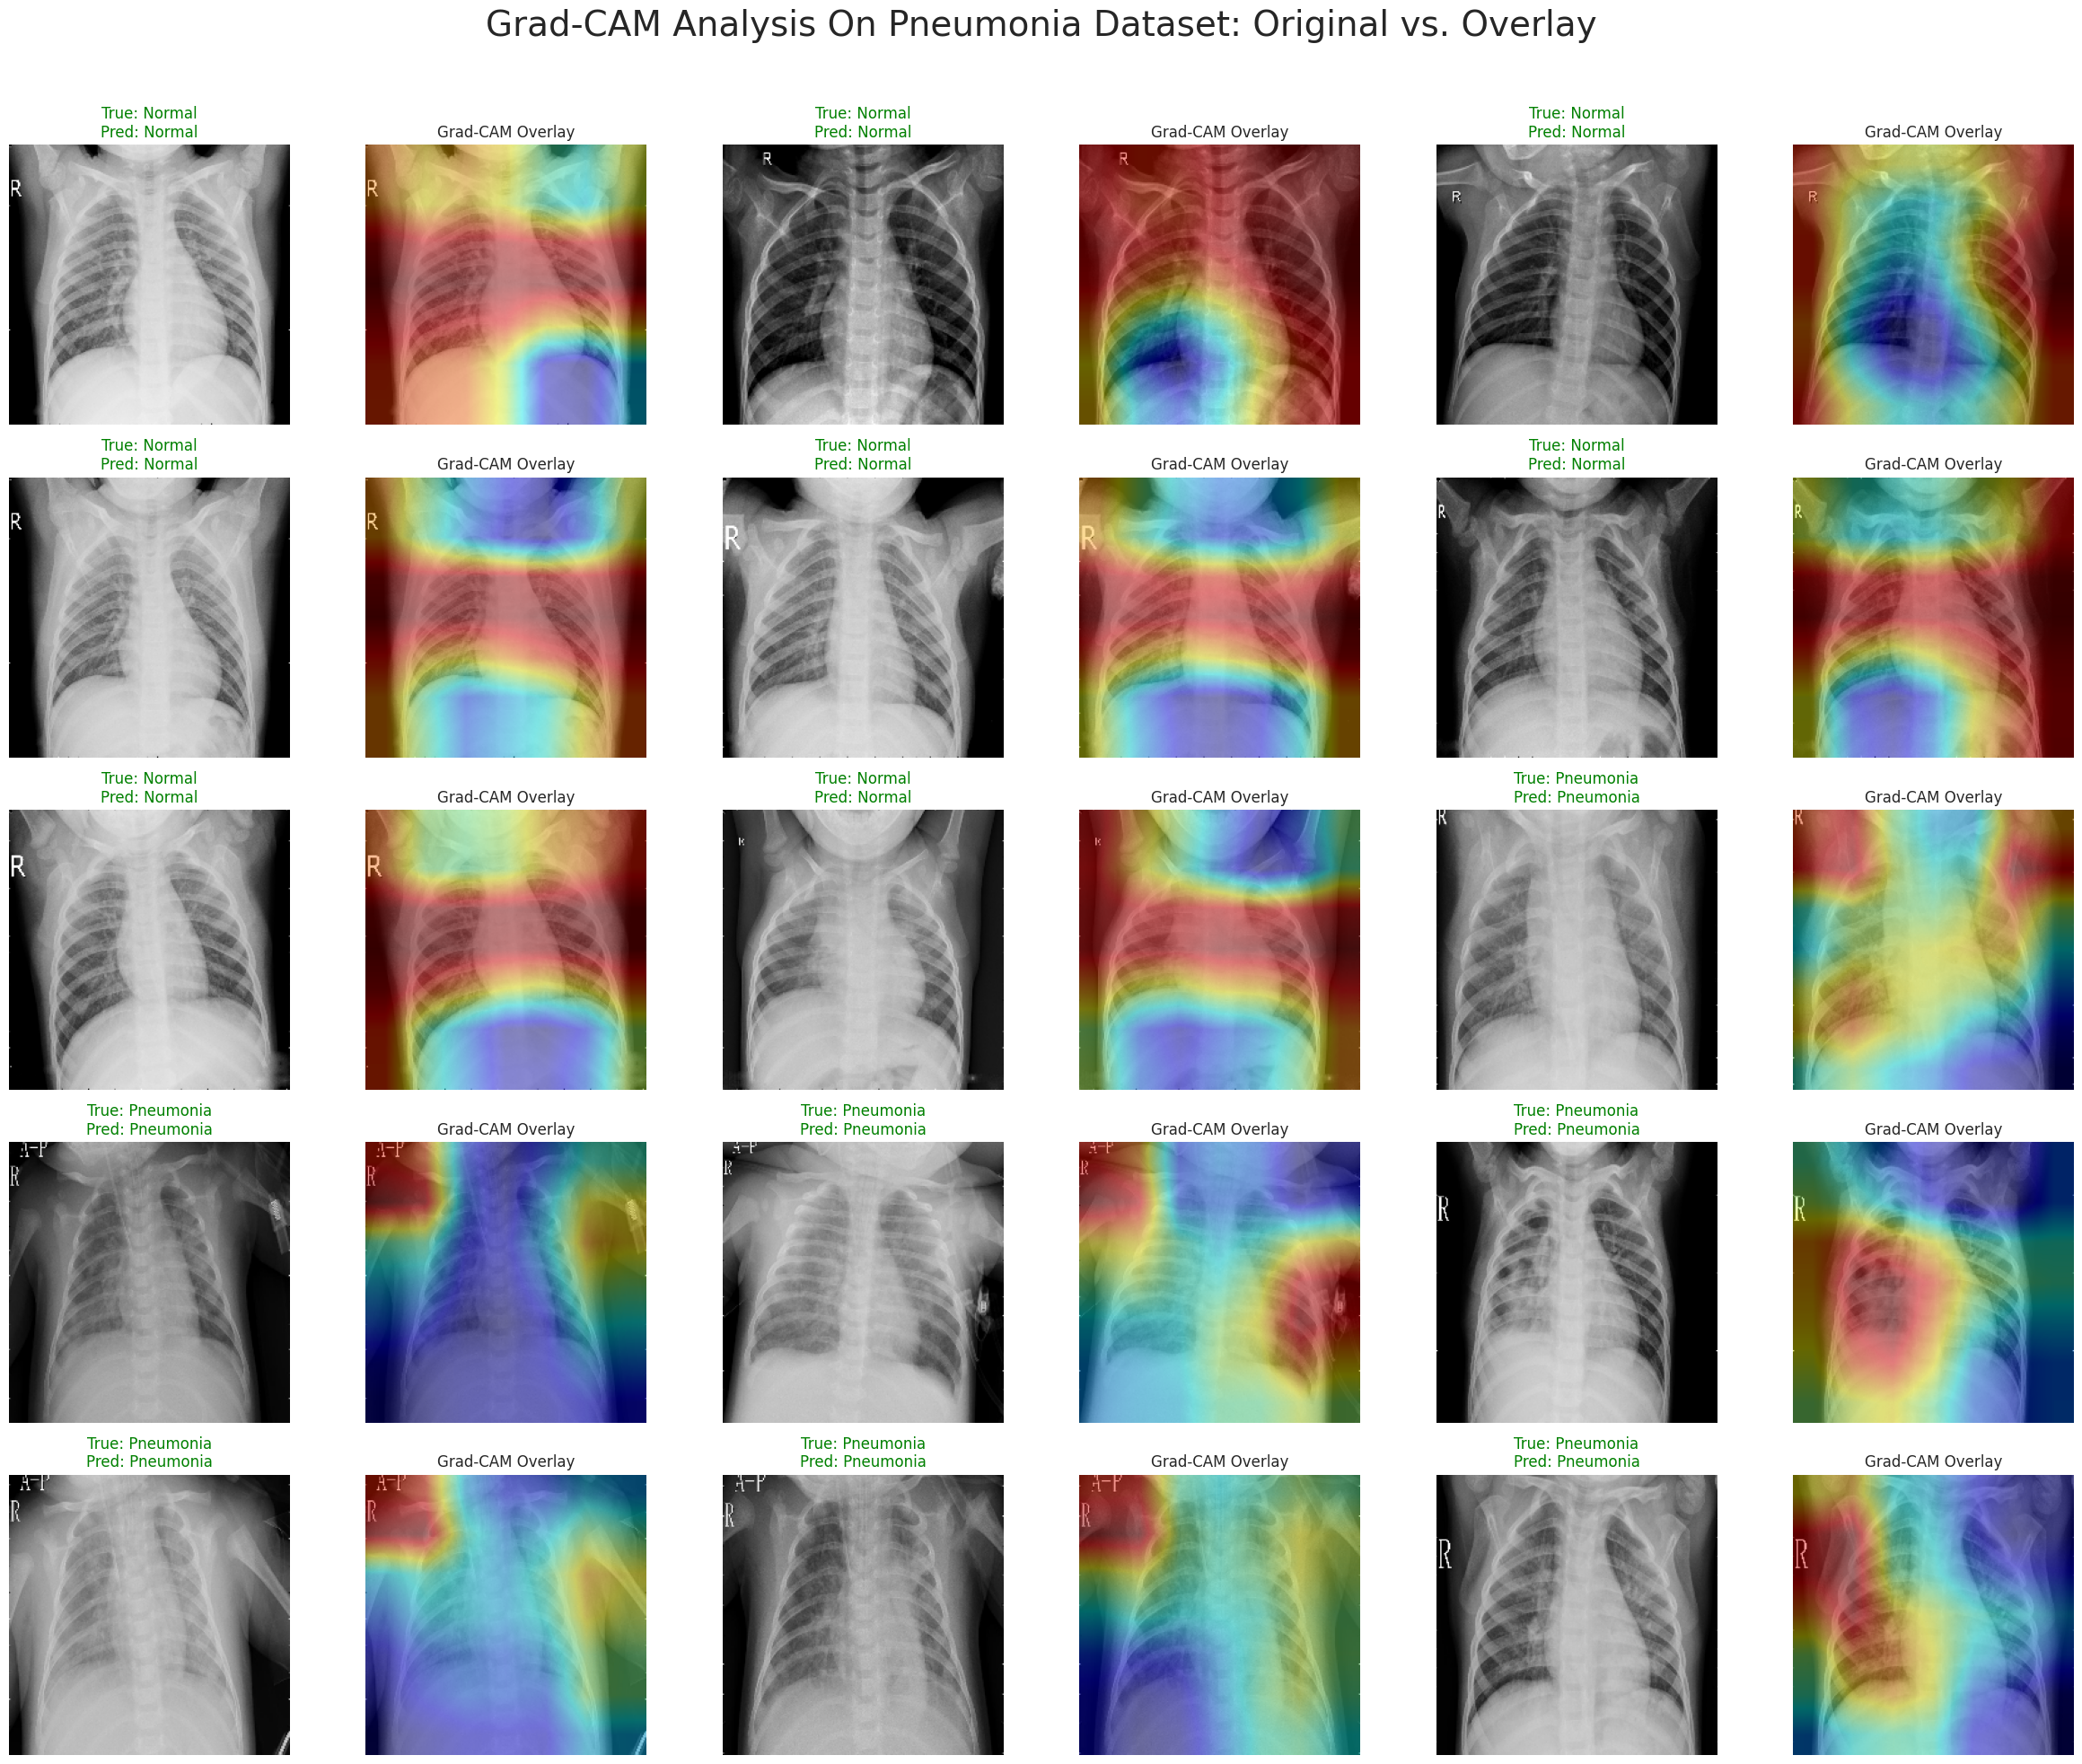

In [9]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import albumentations as A
from albumentations.pytorch import ToTensorV2
from captum.attr import LayerGradCam
import torch.nn.functional as F

# Suppress warnings and set plot style
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
CONFIG = {
    "DATASET_DIR": "/kaggle/input/chest-xray-pneumonia/chest_xray",
    "IMAGE_SIZE": 224,
    "BATCH_SIZE": 32,
    "NUM_EPOCHS": 5,
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "SEED": 42,
    "DROPOUT_RATE": 0.5
}

# Set seed for reproducibility
torch.manual_seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])

# ==============================================================================
# 3. DATA HANDLING & VISUALIZATION
# ==============================================================================
def create_pneumonia_df(dataset_dir):
    data = []
    for split in ['train', 'val', 'test']:
        current_split = 'train' if split == 'train' else 'val'
        split_path = os.path.join(dataset_dir, split)
        if not os.path.isdir(split_path): continue
        for label_str in ['NORMAL', 'PNEUMONIA']:
            label = 0 if label_str == 'NORMAL' else 1
            image_paths = glob.glob(os.path.join(split_path, label_str, "*.jpeg"))
            for img_path in image_paths:
                data.append({'ImagePath': img_path, 'Label': label, 'Split': current_split})
    df = pd.DataFrame(data)
    if df.empty:
        raise FileNotFoundError(f"No .jpeg files found in {dataset_dir}. Check your path.")
    return df

def visualize_data_grid(df, title="Sample Training Images"):
    sample_df = df.sample(25).reset_index(drop=True)
    plt.figure(figsize=(15, 15))
    plt.suptitle(title, fontsize=20)
    for i, row in sample_df.iterrows():
        plt.subplot(5, 5, i + 1)
        img = cv2.imread(row['ImagePath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = "Pneumonia" if row['Label'] == 1 else "Normal"
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def get_transforms(image_size):
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    train_transform = A.Compose([
        A.Resize(image_size, image_size), A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(image_size, image_size), A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()
    ])
    return train_transform, val_transform

class ChestXrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.labels = df['Label'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'ImagePath']
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        original_image = cv2.resize(image, (CONFIG["IMAGE_SIZE"], CONFIG["IMAGE_SIZE"]))
        if self.transform:
            image_tensor = self.transform(image=image)['image']
        else:
            image_tensor = A.Compose([
                A.Resize(CONFIG["IMAGE_SIZE"], CONFIG["IMAGE_SIZE"]),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])(image=image)['image']
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image_tensor, label.unsqueeze(-1), original_image

# ==============================================================================
# 4. MODEL DEFINITION (Using DenseNet-121 with Dropout)
# ==============================================================================
def get_model(num_classes=1, pretrained=True, dropout_rate=0.5):
    model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features, num_classes)
    )
    return model

# ==============================================================================
# 5. ENGINE (TRAIN/EVAL) & PLOTTING FUNCTIONS
# ==============================================================================
def train_one_epoch(model, train_loader, optimizer, criterion, device, scaler):
    model.train(); total_loss = 0.0; all_preds, all_true = [], []
    for images, labels, _ in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(probs.flatten()); all_true.extend(labels.cpu().numpy().flatten())
    y_pred_binary = (np.array(all_preds) > 0.5).astype(int)
    accuracy = accuracy_score(all_true, y_pred_binary)
    return total_loss / len(train_loader), accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval(); total_loss = 0.0; all_preds, all_true = [], []
    with torch.no_grad():
        for images, labels, _ in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images); loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(probs.flatten()); all_true.extend(labels.cpu().numpy().flatten())
    y_pred_probs, y_true = np.array(all_preds), np.array(all_true)
    y_pred_binary = (y_pred_probs > 0.5).astype(int)
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(y_true, y_pred_binary)
    return avg_loss, accuracy, y_pred_binary, y_pred_probs, y_true

def plot_history(history):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], 'o--', label='Train Loss'); plt.plot(history['val_loss'], 'o-', label='Val Loss')
    plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], 'o--', label='Train Accuracy'); plt.plot(history['val_acc'], 'o-', label='Val Accuracy')
    plt.title('Accuracy vs. Epochs'); plt.xlabel('Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

def plot_roc_curves(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs); roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, label=f'Pneumonia (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Validation Set'); plt.legend(loc="lower right"); plt.show()

def plot_confusion_matrices(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix for Validation Set'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

def print_and_plot_metrics(y_true, y_pred_binary, y_pred_probs):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred_binary), 'Precision': precision_score(y_true, y_pred_binary),
        'Recall': recall_score(y_true, y_pred_binary), 'F1-Score': f1_score(y_true, y_pred_binary),
        'MCC': matthews_corrcoef(y_true, y_pred_binary), 'AUROC': roc_auc_score(y_true, y_pred_probs)
    }
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])
    print("\n" + "="*40 + "\n   Final Metrics on Merged Validation Set\n" + "="*40)
    print(metrics_df.to_string(index=False)); print("="*40 + "\n")
    plt.figure(figsize=(10, 6)); sns.barplot(x='Metric', y='Score', data=metrics_df)
    plt.title('Final Validation Metrics'); plt.ylim(0, 1.05)
    for index, row in metrics_df.iterrows():
        plt.text(index, row['Score'] + 0.01, f'{row.Score:.4f}', ha='center', va='bottom')
    plt.show()

# ==============================================================================
# 6. XAI ANALYSIS (GRAD-CAM)
# ==============================================================================
def generate_gradcam_overlay(image_tensor, original_image, model, target_layer):
    model.eval()
    input_tensor = image_tensor.unsqueeze(0).to(CONFIG['DEVICE'])
    lgc = LayerGradCam(model, target_layer)
    attribution = lgc.attribute(input_tensor, target=0)
    heatmap = F.interpolate(attribution, size=(original_image.shape[0], original_image.shape[1]), mode='bilinear', align_corners=False)
    heatmap_np = heatmap.squeeze().cpu().detach().numpy()
    heatmap_np = (heatmap_np - np.min(heatmap_np)) / (np.max(heatmap_np) - np.min(heatmap_np) + 1e-8)
    heatmap_uint8 = np.uint8(255 * heatmap_np)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlayed_image = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)
    return overlayed_image

def xai_analysis(model, data_loader, device):
    print("\n--- 🧠 Performing XAI Analysis (Grad-CAM) ---")
    model.eval()
    images_tensor, labels, original_images_np = next(iter(data_loader))
    target_layer = model.features.denseblock4
    
    with torch.no_grad():
        outputs = model(images_tensor.to(device))
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu()

    num_samples_to_show = 15
    fig, axes = plt.subplots(5, 6, figsize=(24, 20))
    fig.suptitle('Grad-CAM Analysis On Pneumonia Dataset: Original vs. Overlay', fontsize=28)

    for i in range(num_samples_to_show):
        if i >= len(images_tensor): break
        
        row = i // 3
        base_col = (i % 3) * 2
        
        ax_orig = axes[row, base_col]
        ax_grad = axes[row, base_col + 1]

        image_tensor = images_tensor[i]
        original_image = original_images_np[i].numpy()
        true_label = int(labels[i].item())
        pred_label = int(preds[i].item())
        
        overlay = generate_gradcam_overlay(image_tensor, original_image, model, target_layer)
        
        # Plot Original Image with labels
        true_text = "Pneumonia" if true_label == 1 else "Normal"
        pred_text = "Pneumonia" if pred_label == 1 else "Normal"
        color = "green" if true_label == pred_label else "red"
        ax_orig.imshow(original_image)
        ax_orig.set_title(f"True: {true_text}\nPred: {pred_text}", color=color, fontsize=12)
        ax_orig.axis('off')

        # Plot Grad-CAM Overlay
        ax_grad.imshow(overlay)
        ax_grad.set_title("Grad-CAM Overlay", fontsize=12)
        ax_grad.axis('off')
        
    # Hide any unused subplots
    for i in range(num_samples_to_show, 15):
        row = i // 3
        base_col = (i % 3) * 2
        axes[row, base_col].axis('off')
        axes[row, base_col + 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ==============================================================================
# 7. MAIN EXECUTION SCRIPT
# ==============================================================================
if __name__ == '__main__':
    training_successful = False
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    try:
        print(f"--- Training DenseNet-121 on Pneumonia Dataset | Device: {CONFIG['DEVICE']} ---")
        full_df = create_pneumonia_df(CONFIG['DATASET_DIR'])
        train_df = full_df[full_df['Split'] == 'train']
        val_df = full_df[full_df['Split'] == 'val']
        print(f"Data Loaded: {len(train_df)} train images and {len(val_df)} validation images (val + test merged).")
        visualize_data_grid(train_df)
        
        train_transform, val_transform = get_transforms(CONFIG["IMAGE_SIZE"])
        train_loader = DataLoader(ChestXrayDataset(train_df, transform=train_transform), batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(ChestXrayDataset(val_df, transform=val_transform), batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)
        
        model = get_model(num_classes=1, dropout_rate=CONFIG['DROPOUT_RATE']).to(CONFIG['DEVICE'])
        
        pos_counts = train_df['Label'].sum()
        neg_counts = len(train_df) - pos_counts
        pos_weights = neg_counts / pos_counts
        print(f"Class Imbalance: {neg_counts} Normal vs. {pos_counts} Pneumonia. Using pos_weight: {pos_weights:.4f}")
        
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights, dtype=torch.float32).to(CONFIG['DEVICE']))
        optimizer = AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        scaler = torch.cuda.amp.GradScaler()
        
        best_val_loss = float('inf')
        for epoch in range(CONFIG['NUM_EPOCHS']):
            print(f"\n--- Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} ---")
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CONFIG['DEVICE'], scaler)
            val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, CONFIG['DEVICE'])
            history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                print(f"Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
                torch.save(model.state_dict(), 'best_model.pth')
                best_val_loss = val_loss
        training_successful = True
        
    except Exception as e:
        print(f"An error occurred during training or setup: {e}")

    finally:
        if training_successful:
            print("\n\n--- 📈 Final Evaluation on VALIDATION SET (Merged Val+Test) ---")
            model_path = 'best_model.pth'
            if os.path.exists(model_path):
                criterion = nn.BCEWithLogitsLoss()
                model = get_model(num_classes=1, pretrained=False, dropout_rate=CONFIG['DROPOUT_RATE']).to(CONFIG['DEVICE'])
                model.load_state_dict(torch.load(model_path))
                print(f"--- Loaded best model from {model_path} for final evaluation. ---")
                _, _, y_pred_bin_val, y_pred_prob_val, y_true_val = evaluate(model, val_loader, criterion, CONFIG['DEVICE'])
                plot_history(history)
                plot_roc_curves(y_true_val, y_pred_prob_val)
                plot_confusion_matrices(y_true_val, y_pred_bin_val)
                print_and_plot_metrics(y_true_val, y_pred_bin_val, y_pred_prob_val)
                xai_analysis(model, val_loader, CONFIG['DEVICE'])
            else:
                print("--- No model was saved. Skipping final evaluation. ---")
        else:
            print("\n--- Training was interrupted or failed. Skipping final evaluation. ---")